In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

from fbprophet import Prophet

In [2]:
df_sales = pd.read_csv('sales_train_v2.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'],  dayfirst=True)

In [3]:
df_sales_fbprophet = df_sales.loc[(df_sales['item_cnt_day']>0)&
                                (df_sales['item_id']==969)]
df_sales_fbprophet = df_sales_fbprophet.groupby(['date'])['item_cnt_day'].sum().reset_index(name='item_cnt_day_total')
df_sales_fbprophet


,date,item_cnt_day_total
0,2014-06-10,3.0
1,2014-06-11,9.0
2,2014-06-12,12.0
3,2014-06-13,6.0
4,2014-06-14,11.0
...,...,...
131,2015-09-14,1.0
132,2015-09-17,1.0
133,2015-10-09,1.0
134,2015-10-16,1.0


In [4]:
df_sales_fbprophet = df_sales_fbprophet.rename(columns={"date": "ds", "item_cnt_day_total": "y"})
df_sales_fbprophet['floor']=0
df_sales_fbprophet['cap']=df_sales_fbprophet['y'].max()
df_sales_fbprophet

,ds,y,floor,cap
0,2014-06-10,3.0,0,12.0
1,2014-06-11,9.0,0,12.0
2,2014-06-12,12.0,0,12.0
3,2014-06-13,6.0,0,12.0
4,2014-06-14,11.0,0,12.0
...,...,...,...,...
131,2015-09-14,1.0,0,12.0
132,2015-09-17,1.0,0,12.0
133,2015-10-09,1.0,0,12.0
134,2015-10-16,1.0,0,12.0


In [5]:
m = Prophet(daily_seasonality=False, yearly_seasonality=True,growth='logistic')
m.fit(df_sales_fbprophet)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [6]:
# predict a few days into the future so we have a full month in November
future = m.make_future_dataframe(periods=44)
future['floor']=0
future['cap']=df_sales_fbprophet['y'].max()

future.tail()

,ds,floor,cap
175,2015-11-26,0,12.0
176,2015-11-27,0,12.0
177,2015-11-28,0,12.0
178,2015-11-29,0,12.0
179,2015-11-30,0,12.0


In [7]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
175,2015-11-26,-0.307008,-1.889487,1.429392
176,2015-11-27,0.204330,-1.407511,1.904300
177,2015-11-28,0.485672,-1.243991,2.028574
178,2015-11-29,0.399250,-1.195800,2.035585
179,2015-11-30,-0.859863,-2.599548,0.782144


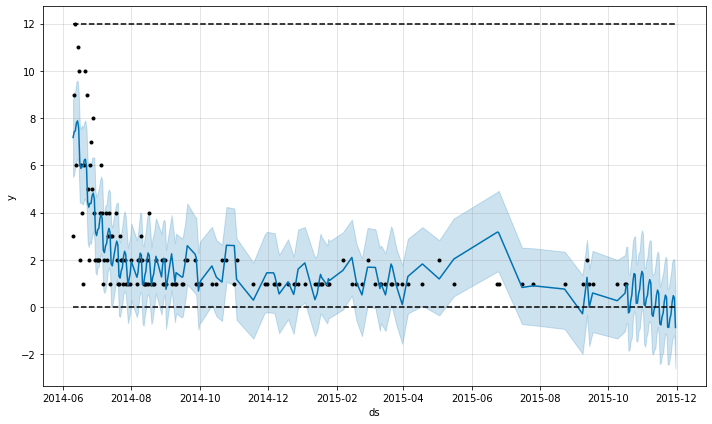

In [8]:
fig1 = m.plot(forecast)

In [9]:
# 31 days of November

In [10]:
forecast['yhat'].tail(31)

149    1.514898
150    1.402656
151    0.110185
152    0.053331
153    0.369596
154    0.499864
155    0.949076
156    1.165565
157    1.013585
158   -0.309909
159   -0.388724
160   -0.085268
161    0.041183
162    0.495171
163    0.724409
164    0.592332
165   -0.705088
166   -0.752775
167   -0.414350
168   -0.250356
169    0.242465
170    0.510568
171    0.416197
172   -0.845772
173   -0.861224
174   -0.494582
175   -0.307008
176    0.204330
177    0.485672
178    0.399250
179   -0.859863
Name: yhat, dtype: float64